In [ ]:
from sys import stdout
import parmed as pmd
# OpenMM imports
import openmm.app as app
import openmm as mm
import openmm.unit as unit
from openmmforcefields.generators import SMIRNOFFTemplateGenerator
from openmm.app import PDBFile
# OpenFF-toolkit imports
from openff.toolkit import Molecule
from openff.toolkit import Topology as offTopology
from openff.units.openmm import to_openmm as offquantity_to_openmm
# Analysis imports
import mdtraj as md
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

Prepare protein-ligand complex System for MD simulation with OpenMM and OpenFF

In [ ]:
# Protein receptor was processed from openmm-setup to ensure correct protonation states
protein_path = "prep/CYPA-processed.pdb"
# Ligand was taken from the bioactive conformation in the PDB (MMFF minimised to recover covalent warhead geometry)
ligand_path = "prep/bioactive_min.sdf"
# OpenFF 2.2.1 (SAGE) is used for the ligand, AMBER ff14SB for the protein and TIP3P for water
ligand = Molecule.from_file(ligand_path)
protein_pdb = app.PDBFile(protein_path)
smirnoff = SMIRNOFFTemplateGenerator(molecules=ligand, forcefield="openff-2.2.1.offxml")
ff = app.ForceField('amber/protein.ff14SB.xml', 'amber/tip3p_standard.xml')
ff.registerTemplateGenerator(smirnoff.generator)

/home/haolan/anaconda3/envs/openmm/lib/python3.10/site-packages/smirnoff99frosst/smirnoff99frosst.py:11: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_filename


In [ ]:
# Create OpenMM Modeller starting with the protein
modeller = app.Modeller(protein_pdb.topology, protein_pdb.positions)
# Make an OpenFF Topology of the ligand and convert it to an OpenMM Topology
ligand_off_topology = offTopology.from_molecules(molecules=[ligand])
ligand_omm_topology = ligand_off_topology.to_openmm()
# Get the positions of the ligand and add the ligand to the Modeller before solvate
ligand_positions = offquantity_to_openmm(ligand.conformers[0])
modeller.add(ligand_omm_topology, ligand_positions)
modeller.addSolvent(ff, padding=1.0*unit.nanometer, ionicStrength=0.15*unit.molar)

/home/haolan/anaconda3/envs/openmm/lib/python3.10/site-packages/openff/interchange/smirnoff/_nonbonded.py:496: UserWarning: Warning! Partial charge method 'am1bcc' is not designed for use on large (i.e. > 150 atoms) molecules and may crash or take hours to run on this molecule (found 151 atoms). For more, see https://docs.openforcefield.org/projects/toolkit/en/stable/faq.html#parameterizing-my-system-which-contains-a-large-molecule-is-taking-forever-whats-wrong
  molecule.assign_partial_charges(method)


In [ ]:
# Create OpenMM Systems and save parameters to XML files, geometry to PDB file
system_1 = ff.createSystem(modeller.topology, nonbondedMethod=app.PME, nonbondedCutoff=1.0*unit.nanometer, constraints=app.HBonds)
with open('openmm/system.xml', 'w') as f:
    f.write(mm.XmlSerializer.serialize(system_1))
with open('openmm/complex_in_solvent.pdb', 'w') as output_pdb:
    PDBFile.writeFile(modeller.topology, modeller.positions, output_pdb)
    
# Create GROMACS Systems (with Parmed) and save topology and coordinates to GROMACS files
system_1_gmx = ff.createSystem(modeller.topology, nonbondedMethod=app.PME, nonbondedCutoff=1.0*unit.nanometer, constraints=None, rigidWater=False)
structure = pmd.openmm.load_topology(modeller.topology, system=system_1_gmx, xyz=modeller.positions)
structure.save('gromacs/gromacs.top', overwrite=True)
structure.save('gromacs/gromacs.gro', overwrite=True)

In [ ]:
# Now create a system with just the ligand in solvent for future use in REST MD conformational analysis
modeller_ligand = app.Modeller(ligand_omm_topology, ligand_positions)
modeller_ligand.addSolvent(ff, padding=1.0*unit.nanometer)

# Create OpenMM Systems and save parameters to XML files, geometry to PDB file
system_0 = ff.createSystem(modeller_ligand.topology, nonbondedMethod=app.PME, nonbondedCutoff=1.0*unit.nanometer, constraints=app.HBonds)
with open('ligand_REST_MD/system_with_ligand_only.xml', 'w') as f:
    f.write(mm.XmlSerializer.serialize(system_0))
with open('ligand_REST_MD/ligand_in_solvent.pdb', 'w') as output_pdb:
    PDBFile.writeFile(modeller_ligand.topology, modeller_ligand.positions, output_pdb)
    
# Create GROMACS Systems (with Parmed) and save topology and coordinates to GROMACS files
system_0_gmx = ff.createSystem(modeller_ligand.topology, nonbondedMethod=app.PME, nonbondedCutoff=1.0*unit.nanometer, constraints=None, rigidWater=False)
structure = pmd.openmm.load_topology(modeller_ligand.topology, system=system_0_gmx, xyz=modeller_ligand.positions)
structure.save('gromacs/gromacs_ligand.top', overwrite=True)
structure.save('gromacs/gromacs_ligand.gro', overwrite=True)


In [ ]:
# OpenMM minimisation and MD simulation of the complex in solvent (10 replicates with different random seeds)
integrator = mm.LangevinMiddleIntegrator(300*unit.kelvin, 1/unit.picosecond, 0.002*unit.picoseconds)
simulation = app.Simulation(modeller.topology, system_1, integrator)
for i in range(1, 11):
    simulation.context.setPositions(modeller.positions)
    integrator.setRandomNumberSeed(i)
    print("Simulation is running on:", simulation.context.getPlatform().getName())
    simulation.minimizeEnergy(maxIterations=1000)
    # save the minimized structure for each replicate as starting-point geometry (almost identical actually...)
    with open(f'openmm/NVT/min_complex_{i}.pdb', 'w') as f:
        PDBFile.writeFile(simulation.topology, simulation.context.getState(getPositions=True).getPositions(), f)
    simulation.context.setVelocitiesToTemperature(300*unit.kelvin)
    # NVT for 10 ns
    simulation.reporters.append(app.DCDReporter(f'openmm/NVT/trajectory_{i}.dcd', 1000))
    simulation.reporters.append(
                                app.StateDataReporter(
                                                        f'openmm/NVT/energy_data_{i}.csv',
                                                        1000,
                                                        step=True,
                                                        time=True, 
                                                        potentialEnergy=True,
                                                        kineticEnergy=True,
                                                        totalEnergy=True,
                                                        temperature=True,
                                                        volume=True,
                                                        density=True,
                                                        speed=True,
                                                      )
                                )
    simulation.step(5000000)
    simulation.reporters.clear()

In [ ]:
with open('openmm/system.xml', 'r') as f:
    system_1 = mm.XmlSerializer.deserialize(f.read())
pdb = PDBFile('openmm/complex_in_solvent.pdb')
#NPT simulations for 10 replicates
system_1.addForce(mm.MonteCarloBarostat(1*unit.atmosphere, 300*unit.kelvin))
integrator = mm.LangevinMiddleIntegrator(300*unit.kelvin, 1/unit.picosecond, 0.002*unit.picoseconds)
simulation = app.Simulation(pdb.topology, system_1, integrator)
for i in range(1, 11):
    simulation.context.setPositions(pdb.positions)
    integrator.setRandomNumberSeed(i)
    print("Simulation is running on:", simulation.context.getPlatform().getName())
    simulation.minimizeEnergy(maxIterations=1000)
    # save the minimized structure for each replicate as starting-point geometry (almost identical actually...)
    with open(f'openmm/NPT/min_complex_{i}.pdb', 'w') as f:
        PDBFile.writeFile(simulation.topology, simulation.context.getState(getPositions=True).getPositions(), f)
    simulation.context.setVelocitiesToTemperature(300*unit.kelvin)
    # NPT for 10 ns
    simulation.reporters.append(app.DCDReporter(f'openmm/NPT/trajectory_{i}.dcd', 1000))
    simulation.reporters.append(
                                app.StateDataReporter(
                                                        f'openmm/NPT/energy_data_{i}.csv',
                                                        1000,
                                                        step=True,
                                                        time=True, 
                                                        potentialEnergy=True,
                                                        kineticEnergy=True,
                                                        totalEnergy=True,
                                                        temperature=True,
                                                        volume=True,
                                                        density=True,
                                                        speed=True,
                                                      )
                                )
    simulation.step(5000000)
    simulation.reporters.clear()


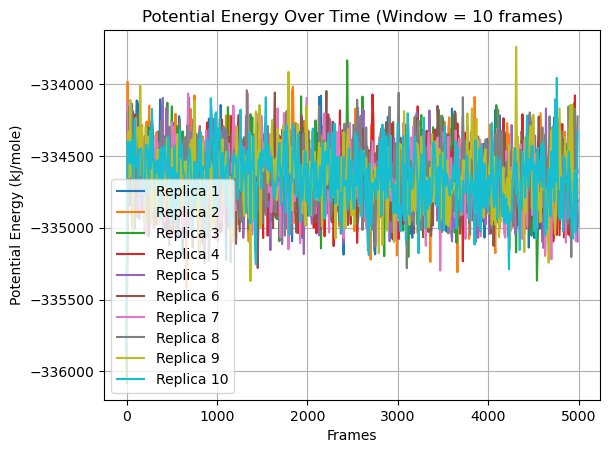

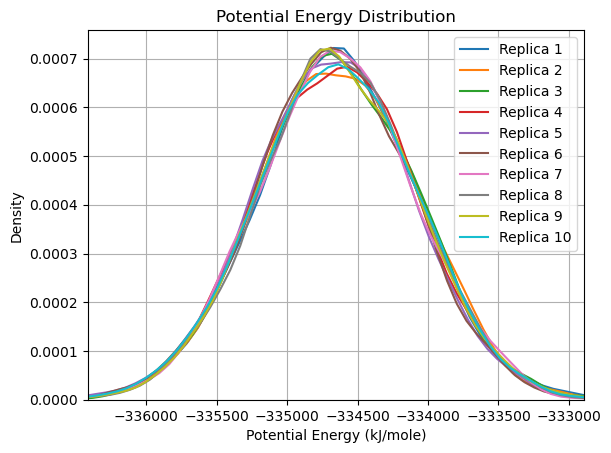

In [29]:
import mdtraj as md
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def plot_potential_energy(state_file_list, type, window=10):
    energy_arrays = []
    labels = []
    for i, state_file in enumerate(state_file_list):
        df = pd.read_csv(state_file)
        energy = df['Potential Energy (kJ/mole)'].to_numpy()
        n_windows = len(energy) // window
        avg_energy = np.array([energy[i*window:(i+1)*window].mean() for i in range(n_windows)])
        avg_frames = np.arange(n_windows) * window
        energy_arrays.append(avg_energy)
        labels.append(f'Replica {i+1}')
        if type == 'line':
            plt.plot(avg_frames, avg_energy, label=labels[-1])
            plt.xlabel('Frames')
            plt.ylabel('Potential Energy (kJ/mole)')
            plt.title(f'Potential Energy Over Time (Window = {window} frames)')
        elif type == 'hist':
            sns.kdeplot(energy, label=labels[-1])
            plt.xlabel('Potential Energy (kJ/mole)')
            plt.title('Potential Energy Distribution')
            plt.xlim(np.mean(energy) - 3*np.std(energy), np.mean(energy) + 3*np.std(energy))
    plt.grid(True)
    plt.legend()
    plt.show()
    plt.close()
    return energy_arrays

csv_files = [f'openmm/energy_data_{i}.csv' for i in range(1, 11)]
energy_arrays = plot_potential_energy(csv_files, 'line', window=10)
energy_arrays = plot_potential_energy(csv_files, 'hist', window=10)

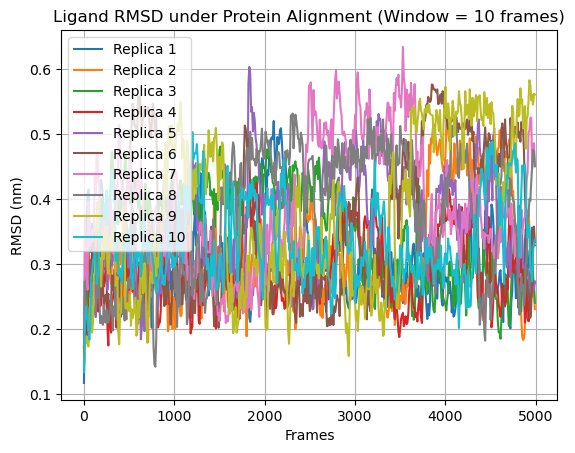

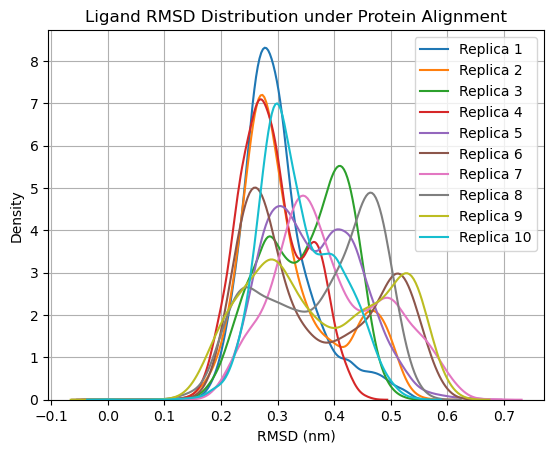

In [27]:
def plot_rmsd_fluctuations_multiple(traj_files, top_file, type, window=10):
    rmsd_arrays = []
    labels = []
    for i, traj_file in enumerate(traj_files):
        traj = md.load(traj_file, top=top_file)
        traj.image_molecules(inplace=True)
        frames = np.arange(0, traj.n_frames)
        protein_atoms = traj.topology.select('protein and name CA')
        ligand_atoms = traj.topology.select('resname UNK')
        traj.superpose(traj, frame=0, atom_indices=protein_atoms)
        result = traj.xyz[:, ligand_atoms, :] - traj.xyz[0, ligand_atoms, :]
        ligand_rmsd = np.sqrt((result ** 2).sum(axis=-1).mean(axis=-1))
        # Average every 'window' frames
        n_windows = len(ligand_rmsd) // window
        avg_rmsd = np.array([ligand_rmsd[i*window:(i+1)*window].mean() for i in range(n_windows)])
        avg_frames = np.arange(n_windows) * window
        rmsd_arrays.append(avg_rmsd)
        labels.append(f'Replica {i+1}')
        if type == 'line':
            plt.plot(avg_frames, avg_rmsd, label=labels[-1])
            plt.xlabel('Frames')
            plt.ylabel('RMSD (nm)')
            plt.title(f'Ligand RMSD under Protein Alignment (Window = {window} frames)')
        elif type == 'hist':
            sns.kdeplot(ligand_rmsd, label=labels[-1])
            plt.xlabel('RMSD (nm)')
            plt.title('Ligand RMSD Distribution under Protein Alignment')
    plt.grid(True)
    plt.legend()
    plt.show()
    plt.close()
    return rmsd_arrays

traj_files = [f'openmm/trajectory_{i}.dcd' for i in range(1, 11)]
top_file = 'openmm/min_complex_1.pdb'
rmsd_arrays = plot_rmsd_fluctuations_multiple(traj_files, top_file, 'line', window=10)
rmsd_arrays = plot_rmsd_fluctuations_multiple(traj_files, top_file, 'hist', window=10)